# Proyecto IA - Aprendizaje por Refuerzo
---

## Integrantes
- Andrés Francisco García Rivero
- Jorge Muñoz Rodríguez

### Apartado 1: Implementación mediante Q-Learning

In [364]:
import numpy as np
import mdptoolbox.mdp as mdp
import matplotlib.pyplot as plt

In [365]:
# Leer el mapa
def lee_mapa(fichero):
    with open(fichero,'r') as archivo:
        lineas = archivo.readlines()
    numeros = [float(numero) for numero in lineas[0].split()]
    lineas.pop(0)
    lineas.reverse()
    matriz = []
    for linea in lineas:
        fila = [int(caracter) for caracter in linea.strip()]
        matriz.append(fila)
    return np.array(matriz).T,(int(numeros[0]),int(numeros[1]))

mapa,destino = lee_mapa("map.txt")
print(destino)

(40, 7)


In [366]:
# Parámetros del entorno
n,m = mapa.shape
Perror = 0.1  # Probabilidad de error en el movimiento
print(m,n)

15 51


In [367]:
# Posiciones inicial y final
Pinit = np.random.randint(n),np.random.randint(m)
while mapa[Pinit] == 1 or Pinit == destino:
    Pinit = np.random.randint(n),np.random.randint(m)
Pend = (destino[0], destino[1])

print("Posición inicial:", Pinit)
print("Posición final:", Pend)

Posición inicial: (18, 7)
Posición final: (40, 7)


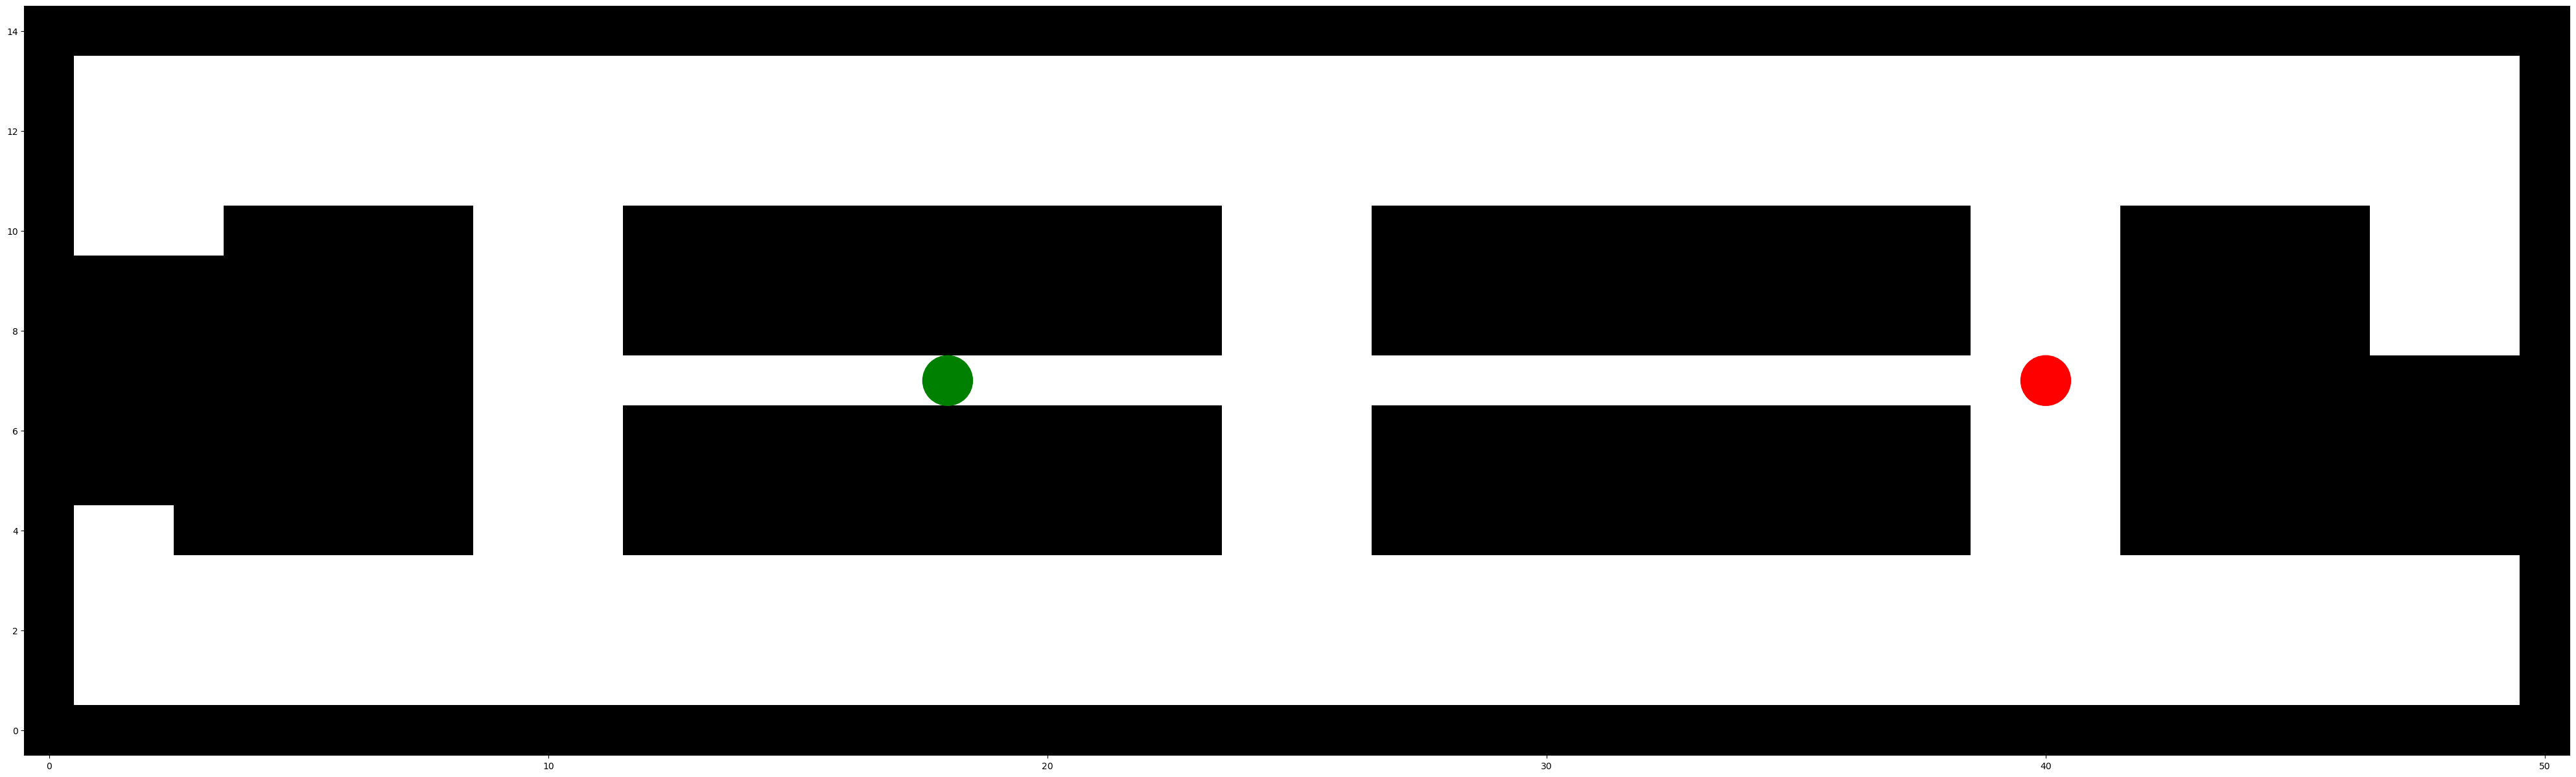

In [368]:
def visualiza_mapa():
    mapa_visual = np.copy(mapa).T
    plt.figure(figsize=(len(mapa_visual[0]), len(mapa_visual)))
    plt.imshow(1-mapa_visual, cmap='gray', interpolation='none')
    plt.xlim(-0.5, len(mapa_visual[0]) - 0.5)
    plt.ylim(-0.5, len(mapa_visual) - 0.5)
    plt.gca().add_patch(plt.Circle(destino,radius = 0.5,edgecolor = 'red', facecolor = 'red'))
    plt.gca().add_patch(plt.Circle(Pinit,radius = 0.5,edgecolor = 'green', facecolor = 'green'))

visualiza_mapa()

In [369]:
# Definición de acciones
acciones = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'wait']
num_acciones = len(acciones)

In [370]:
# Definición de movimientos y errores
movimientos = {
    'N': (-1, 0), 'NE': (-1, 1), 'E': (0, 1), 'SE': (1, 1),
    'S': (1, 0), 'SW': (1, -1), 'W': (0, -1), 'NW': (-1, -1)
}
errores = {
    'N': ['NE', 'NW'], 'NE': ['N', 'E'], 'E': ['NE', 'SE'], 'SE': ['E', 'S'],
    'S': ['SE', 'SW'], 'SW': ['S', 'W'], 'W': ['SW', 'NW'], 'NW': ['N', 'W']
}

In [384]:
# def transicion(s, a):
#     if mapa[s] == 1:
#         return s
#     if a == 'wait': # Si la acción es esperar o se ha llegado al objetivo*****
#         return s

#     if np.random.random() < Perror:
#         a_prime = np.random.choice(errores[a])
#         mov = movimientos[a_prime]
#     else:
#         mov = movimientos[a]

#     s_prime = (s[0] + mov[0], s[1] + mov[1])
#     if s_prime[0] < 0 or s_prime[0] >= n or s_prime[1] < 0 or s_prime[1] >= m:
#         return s
#     return s_prime

def hay_colision(estado):
    return mapa[estado]==1

def transicion(estado,accion):
    if hay_colision(estado):
        return estado
    x = estado[0]
    y = estado[1]
    
    if accion == 'N':
        y += 1
    elif accion == 'S':
        y -= 1
    elif accion == 'E':
        x += 1
    elif accion == 'O':
        x -= 1
    elif accion == 'NE':
        y += 1
        x += 1
    elif accion == 'SE':
        y -= 1
        x += 1
    elif accion == 'SO':
        y -= 1
        x -= 1
    elif accion == 'NO':
        y += 1
        x -= 1
    return x,y

In [404]:
transicion((0,0),'E')

(0, 0)

In [410]:
# Función de recompensa
K1 = -100
K2 = -1000

# def recompensa(s, a, s_prime):
#     if mapa[s_prime] == 1: # Si el siguiente estado es un obstáculo
#         return K2
#     elif a == 'wait' and s_prime != Pend: # Si la acción es esperar y no se ha llegado al objetivo
#         return K1
#     else:
#         return - np.sqrt((s_prime[0] - Pend[0])**2 + (s_prime[1] - Pend[1])**2) # Distancia euclídea al objetivo

def obtiene_recompensa(estado):
    if hay_colision(estado):
        valor = K2
    else:
        valor = - np.sqrt( (estado[0]-destino[0])**2 + (estado[1]-destino[1])**2)
    return valor

In [422]:
nav_estados = []
for i in range(0,mapa.shape[0]):
    for j in range(0,mapa.shape[1]):
        nav_estados.append(tuple([i,j]))

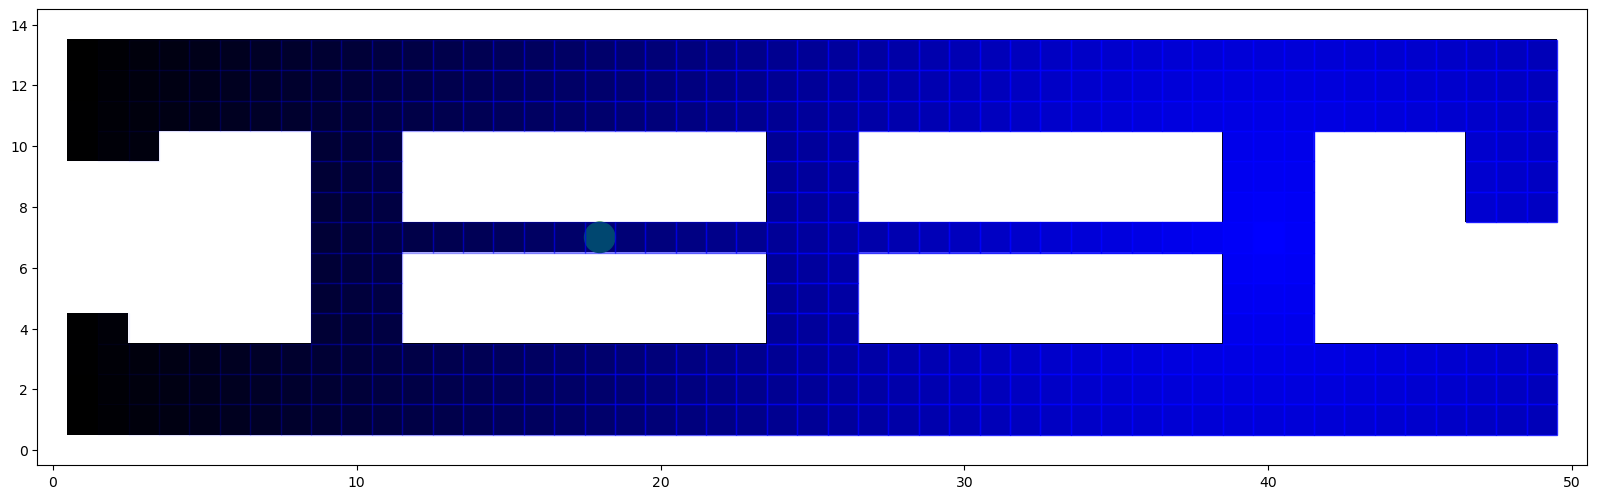

In [421]:
def visualiza_recompensas():
    visualiza_mapa()
    recompensas = [obtiene_recompensa(e) for e in nav_estados]
    recompensas = [np.nan if elemento == -1000 else elemento for elemento in recompensas]
    max_recompensa = np.nanmax(recompensas)
    min_recompensa = np.nanmin(recompensas)
    for e in nav_estados:
        r = obtiene_recompensa(e)
        if r == -1000:
            continue
        a = (r-min_recompensa)/(max_recompensa-min_recompensa)
        rect = plt.Rectangle((e[0] - 0.5, e[1] - 0.5), 1, 1, alpha = a,linewidth=1, edgecolor='blue', facecolor='blue')
        plt.gca().add_patch(rect)

visualiza_recompensas()

In [373]:
# Creación de las matrices de transición y recompensa
num_states = m * n
T = np.zeros((num_acciones, num_states, num_states))
R = np.zeros((num_states, num_acciones))

In [374]:
# Creación de las matrices de transición y recompensa
num_states = n * m
T = np.zeros((num_acciones, num_states, num_states))
R = np.zeros((num_states, num_acciones))

# Rellenar las matrices T y R
for i in range(n):
    for j in range(m):
        for k, a in enumerate(acciones):
            s = (i, j)
            s_index = i * m + j
            if mapa[s] == 1:
                T[k, s_index, s_index] = 1
                R[s_index, k] = recompensa(s, a, s)
                continue

            s_prime = transicion(s, a)
            s_prime_index = s_prime[0] * m + s_prime[1]
            if 0 <= s_prime_index < num_states:
                T[k, s_index, s_prime_index] = 1 - Perror
                R[s_index, k] = recompensa(s, a, s_prime)

            if a != 'wait':
                for a_prime in errores[a]:
                    s_error = transicion(s, a_prime)
                    s_error_index = s_error[0] * m + s_error[1]
                    if 0 <= s_error_index < num_states:
                        T[k, s_index, s_error_index] += Perror / 2

In [375]:
# Normalizar las filas de la matriz de transición
for k in range(num_acciones):
    for i in range(m*n):
        if T[k, i].sum() > 0:
            T[k, i] /= T[k, i].sum()

In [376]:
# Convertir las matrices a formato compatible con mdptoolbox
T = [T[i] for i in range(num_acciones)]

In [377]:
print(f"T shape: {[t.shape for t in T]}")
print(f"R shape: {R.shape}")

T shape: [(765, 765), (765, 765), (765, 765), (765, 765), (765, 765), (765, 765), (765, 765), (765, 765), (765, 765)]
R shape: (765, 9)


In [381]:
# Implementación de Q-Learning con mdptoolbox
ql = mdp.QLearning(transitions=T, reward=R, discount=0.95, n_iter=300000)
ql.run()

In [382]:
print("Política óptima:")
print(ql.policy)
print(len(ql.policy))
print("Acciones" + str(acciones))

# Visualización de la política óptima
i = 0
for action in ql.policy:
    print("Decisión en el estado ", i, "( " + str(i // m) + ", " + str(i % m) + "): ", acciones[action])
    i+=1


Política óptima:
(3, 8, 2, 2, 4, 7, 5, 6, 7, 6, 6, 8, 6, 7, 8, 7, 3, 8, 3, 4, 3, 0, 6, 0, 5, 3, 4, 4, 5, 8, 1, 8, 4, 0, 8, 5, 0, 8, 8, 2, 3, 4, 0, 7, 8, 4, 3, 1, 6, 1, 3, 2, 3, 1, 8, 2, 8, 4, 3, 4, 4, 3, 3, 5, 7, 8, 7, 1, 0, 5, 1, 3, 5, 8, 1, 0, 1, 1, 4, 6, 2, 7, 3, 7, 5, 2, 3, 2, 5, 2, 7, 1, 8, 6, 0, 5, 6, 0, 8, 2, 8, 0, 3, 5, 6, 6, 2, 3, 7, 5, 1, 6, 5, 2, 5, 6, 1, 6, 4, 4, 5, 3, 2, 8, 7, 4, 4, 5, 5, 0, 7, 1, 6, 5, 1, 6, 1, 1, 7, 2, 3, 8, 5, 3, 6, 4, 7, 2, 5, 5, 8, 3, 6, 6, 4, 6, 2, 1, 6, 3, 8, 2, 8, 6, 2, 8, 3, 4, 6, 7, 6, 0, 1, 8, 7, 1, 7, 8, 4, 8, 6, 3, 7, 0, 7, 7, 0, 0, 1, 8, 4, 1, 3, 5, 1, 6, 2, 0, 8, 0, 3, 5, 8, 0, 0, 7, 2, 3, 0, 7, 7, 3, 1, 4, 5, 2, 5, 0, 3, 5, 0, 2, 1, 0, 6, 5, 3, 2, 6, 3, 6, 4, 4, 4, 3, 1, 1, 4, 7, 7, 5, 4, 6, 5, 6, 2, 3, 8, 5, 5, 1, 4, 2, 5, 1, 6, 3, 4, 4, 6, 3, 4, 8, 5, 0, 8, 2, 2, 6, 1, 8, 1, 2, 5, 8, 0, 5, 0, 3, 8, 0, 3, 5, 5, 2, 1, 2, 2, 7, 4, 2, 2, 8, 5, 3, 1, 0, 0, 6, 5, 7, 3, 5, 8, 0, 2, 2, 4, 3, 4, 5, 0, 0, 5, 4, 2, 3, 5, 7, 4, 4, 4, 7, 6, 6, 3, 2, 2

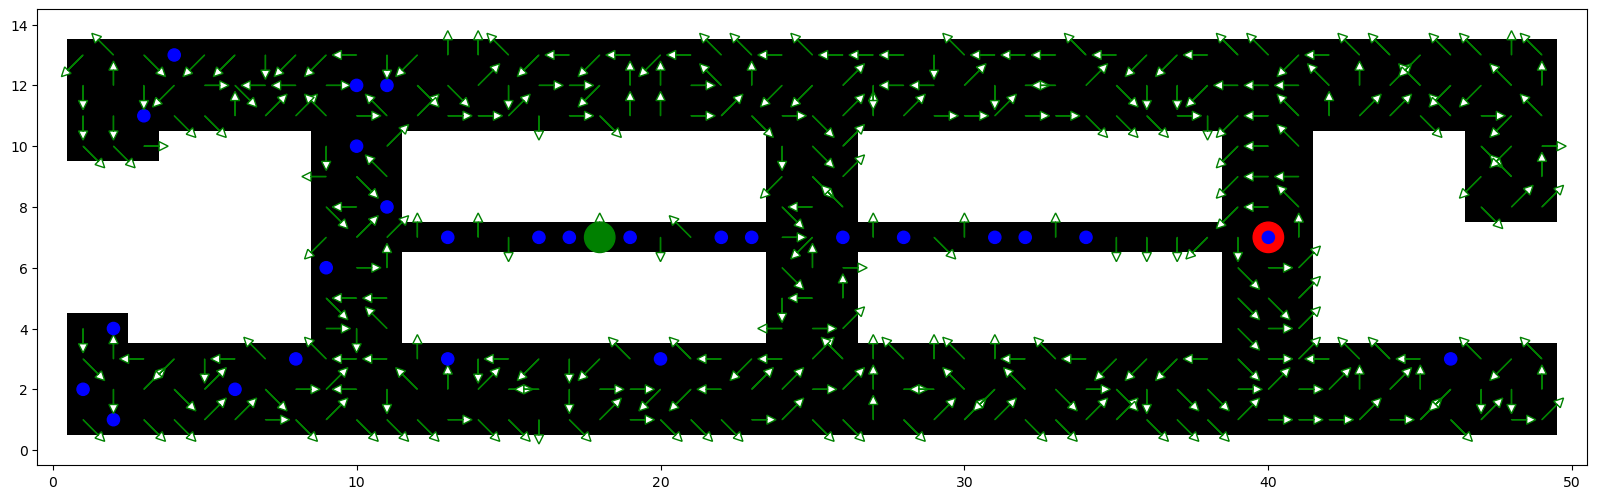

In [383]:
# Definir un diccionario para mapear índices de acciones a desplazamientos
movimientos = {
    'n': (0, 1), 'ne': (1, 1), 'e': (1, 0), 'se': (1, -1),
    's': (0, -1), 'sw': (-1, -1), 'w': (-1, 0), 'nw': (-1, 1), 'wait': (0, 0)
}

# Lista de acciones
acciones = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'wait']

def aplica_accion(estado, accion):
    mov = movimientos[accion]
    return (estado[0] + mov[0], estado[1] + mov[1])

def visualiza_mapa():
    plt.figure(figsize=(20, 20))
    plt.imshow(mapa.T, cmap='gray', origin='lower')
    plt.gca().add_patch(plt.Circle((destino), radius=0.5, edgecolor='red', facecolor='red'))
    plt.gca().add_patch(plt.Circle((Pinit), radius=0.5, edgecolor='green', facecolor='green'))

def visualiza_politica(politica):
    visualiza_mapa()
    for i in range(n):
        for j in range(m):
            if mapa[i, j] == 0:
                s_index = i * m + j
                accion = acciones[politica[s_index]].lower()
                if accion == 'wait':
                    plt.gca().add_patch(plt.Circle((i,j), radius=0.2, edgecolor='blue', facecolor='blue'))
                    continue
                estado = (i, j)
                e1 = aplica_accion(estado, accion)
                x0, y0 = estado[0], estado[1]
                x1, y1 = e1[0], e1[1]

                plt.gca().arrow(x0, y0, (x1 - x0) * 0.5, (y1 - y0) * 0.5, head_width=0.3, head_length=0.3, fc='white', ec='green')
    plt.show()
visualiza_politica(ql.policy)

In [363]:
i = 0
for action in ql.policy:
    if(action == 8):
        print("wait en el estado ", i)
    i+=1

wait en el estado  15
wait en el estado  16
wait en el estado  22
wait en el estado  26
wait en el estado  38
wait en el estado  39
wait en el estado  64
wait en el estado  67
wait en el estado  79
wait en el estado  85
wait en el estado  98
wait en el estado  113
wait en el estado  168
wait en el estado  178
wait en el estado  198
wait en el estado  199
wait en el estado  200
wait en el estado  214
wait en el estado  222
wait en el estado  230
wait en el estado  238
wait en el estado  259
wait en el estado  274
wait en el estado  278
wait en el estado  318
wait en el estado  319
wait en el estado  320
wait en el estado  325
wait en el estado  346
wait en el estado  366
wait en el estado  393
wait en el estado  415
wait en el estado  435
wait en el estado  449
wait en el estado  460
wait en el estado  486
wait en el estado  505
wait en el estado  534
wait en el estado  554
wait en el estado  562
wait en el estado  579
wait en el estado  634
wait en el estado  636
wait en el estado  660